# Notebook 5: AlphaPose and Downstream Modelling Density Heatmap 

This notebook uses the output results obtained from the AlphaPose and Downstream Modelling Pipeline (See notebook 4A) and uses them to produce a dashboard density heatmap plot.

It was seperated out into this individual notebook to reduce the excessive length and complexity of the Downstream Modelling notebook (4A).

**Required TO-DO:**
- Integration of Pose Classification Model results into analysis
- Improve on density heatmap to give much cleaner results, using a constant set of homography parameters for the entire scene (this will prevent the plot bouncing around and looking strange).
- Work out a means of getting a suitable underlay of the top-down area for the scene, which will help represent the risky locations throughout that scene more effectively.
- Extend the work with heatmaps to produce a heatmap averaged over n timeframes, which will give an overall risk rating heatmap for that area over a designated time-period.

## 1. Installation of dependencies / Importing packages

Install MXNet and Gluoncv libraries. If GPU is in use, also install mxnet-cu101 (requires runtime restart after):

In [27]:
import cv2
import io

import os
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib.lines import Line2D
import seaborn as sns
from tqdm import tqdm

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [28]:
sns.set_style('white')

## 2. Load Results from Downstream Models

### 2.1 Set-up Project and Results Directories

For this you need to run the downstream modelling notebook (Notebook 4A) and obtain the final output JSON results for persons and top-level scenes. 

These will be loaded as JSON strings, and processed into a pandas dataframe to allow plotting and visualisation of the density heatmap / show other useful results for the final dashboard.

The idea will be that the functions in this notebook form part of the API and front-end application components, which process the results as required to give us the final dashboard components.

**Option 1**: If working locally on laptop, in file system outside main repo:

In [29]:
os.getcwd()

'/Users/benjaminfraser/Desktop/Multipose_experiments'

In [114]:
# get project path and other key directories for project
PROJECT_PATH = '/Users/benjaminfraser/Desktop'

# set path to test videos to use in this notebook
TEST_VIDEO_DIR = os.path.join(PROJECT_PATH, 'test_video_data')

**Option 2**: If running code locally within cloned GitHub repo:

In [115]:
# get project path and other key directories for project
#PROJECT_PATH = os.sep.join(os.getcwd().split(os.sep)[:-1])
#DATA_DIR = os.path.join(PROJECT_PATH, 'data')

# set path to test videos to use in this notebook
#TEST_VIDEO_DIR = os.path.join(DATA_DIR, 'test_videos')

Set up main environment variables for the above mask classification model:

We can now apply this AlphaPose model on a desired video / stream, by making predictions on each frame as it is received. We'll do this for an example video, as shown below:

### 2.2 Configure test video / scenes location for running our script:

Set path to .mp4 video to run pipeline on:

In [116]:
# set filename and path for chosen test video for this notebook
TEST_VIDEO_FILE = 'campus_1.mp4'
TEST_VIDEO_FILEPATH = os.path.join(TEST_VIDEO_DIR, TEST_VIDEO_FILE)

# obtain path to results for given video (located in same directory)
PERSON_RESULTS_FILEPATH = os.path.join(TEST_VIDEO_DIR, 
                            f"{TEST_VIDEO_FILE[:-4]}_person_results.JSON")
FRAME_RESULTS_FILEPATH = os.path.join(TEST_VIDEO_DIR, 
                            f"{TEST_VIDEO_FILE[:-4]}_frame_results.JSON")

In [117]:
# load JSON frame results file as pandas dataframes
frame_results = pd.read_json(FRAME_RESULTS_FILEPATH)
frame_results.head()

,image_id,person_count,clusters_count,social_distancing_compliance,mask_proportions,frame_H,frame_theta,frame_f,frame_dim_x,frame_dim_y
0,frame_0,8,2,0.250000,0.250000,2.554553,0.576498,444.740973,1024,485
1,frame_5,9,2,0.111111,0.333333,3.491047,0.614651,539.004317,1024,485
2,frame_10,9,2,0.111111,0.333333,3.805518,0.604340,597.944694,1024,485
3,frame_15,9,2,0.000000,0.333333,5.563640,0.716891,921.612521,1024,485
4,frame_20,10,2,0.000000,0.600000,5.295148,0.709228,867.947228,1024,485


In [118]:
# load JSON frame person results file as pandas dataframes
person_results = pd.read_json(PERSON_RESULTS_FILEPATH)
person_results.head()

,image_id,bbox,keypoints,confidences,position,in_cluster,respect_social_distancing,mask_preds,mask_pred_probs,mask_head_regions
0,frame_0,"[456.0, 143.0, 550.0, 385.0]","[[497.125, 192.15625], [497.125, 192.15625], [...","[[0.0150153972], [0.0166315492], [0.0142668430...","[-0.07988895700000001, -1.3431437165]",1,0,0,"[0.8557123542, 0.14428766070000001]","[472, 162, 56, 56]"
1,frame_0,"[340.0, 202.0, 438.0, 484.0]","[[386.9583435059, 263.6875], [386.9583435059, ...","[[0.5421698689000001], [0.4973727167], [0.5392...","[-0.8217262415000001, -1.9554725056]",1,0,1,"[0.15879622100000002, 0.8412038088]","[350, 223, 69, 69]"
2,frame_0,"[570.0, 40.0, 638.0, 203.0]","[[605.4166870117, 75.65625], [606.8333129883, ...","[[0.8332034945000001], [0.9014892578], [0.8185...","[1.264610971, 1.8743114449]",0,1,0,"[0.8565556407, 0.1434443891]","[584, 52, 41, 41]"
3,frame_0,"[469.0, 0.0, 514.0, 96.0]","[[496.1875, 1.5], [484.0, 34.5], [477.4375, 31...","[[0.0048622992000000005], [0.00185993720000000...","[-0.5381903208000001, 8.6627181043]",0,0,0,"[0.8367882967, 0.1632116288]","[473, 24, 29, 29]"
4,frame_0,"[386.0, 0.0, 429.0, 86.0]","[[405.7083435059, 73.90625], [420.0416564941, ...","[[0.0012897616000000002], [0.0018837501], [0.0...","[-2.6566999201, 8.6922341126]",1,0,0,"[0.8003365397000001, 0.1996634454]","[399, 53, 29, 29]"


### 2.3 Set main environmental config / variables:

Set basic variables for our results below:

In [119]:
# define modelling fps used for results
MODELLING_FPS = 5

# dictionaries mapping outputs from models to useful labels
MASK_PREDS_IDS = { 0 : 'No Mask', 1 : 'Mask'}
SOCIAL_DIST_IDS = { 0 : 'Violating Distance', 1 : 'Safe Distance'}

# specify marker colors depending on mask status
MASK_COLOR_MAP = {'No Mask' : 'tab:red', 'Mask' : 'tab:blue'}

# specify marker style depending on social distancing violation status
DIST_STYLE_MAP = {'Violating Distance' : 'X', 'Safe Distance' : 'o'}

In [120]:
# set matplotlib inline if displaying result plots
%matplotlib inline 

# reset seaborn to whitegrid by default
sns.set_style('white')

## 3. Experimentation with weights and density heatmap generation

In [121]:
# reset plotting settings (if not already done)
%matplotlib inline
sns.set_style('white')

We'll be plotting a density heatmap using a weighted Kernel Density Estimation (KDE) model, with a Gaussian-based kernel, defined as follows:

$ p(\textbf{x} | D ) = \displaystyle\frac{1}{N}\sum_{n=1}^{N} \alpha_{risk} K_{h} (\textbf{x} - \textbf{x}_{n}) $

Where $ K_{h} $ is a Gaussian kernel, defined as follows:

$ K_{h}(\textbf{x}) = \displaystyle\frac{1}{h^{D}(2\pi)^{D/2}} \prod_{d = 1}^{D} exp(- \frac{1}{2h^{2}} x_{d}^{2} ) $

Where $ h $ is a bandwidth parameter that represents the width of our kernel.

In addition, the weight $ \alpha_{risk} $ for each data sample is determined using the risk-based factors extracted for each person in the scene from our downstream models.

In [122]:
person_results['image_id'].unique()

array(['frame_0', 'frame_5', 'frame_10', 'frame_15', 'frame_20',
       'frame_25', 'frame_30', 'frame_35', 'frame_40', 'frame_45',
       'frame_50', 'frame_55', 'frame_60', 'frame_65', 'frame_70',
       'frame_75', 'frame_80', 'frame_85', 'frame_90', 'frame_95',
       'frame_100', 'frame_105', 'frame_110', 'frame_115', 'frame_120',
       'frame_125'], dtype=object)

Get the required parameters for plotting density heatmap for a random chosen frame:
- Top-down position co-ordinates of each person in scene (frame_posns)
- Homography parameters for chosen scene (frame_params)
- Image dimensions for chosen frame (img_dims)

In [123]:
# select frame from results above for plotting
frame_id = 'frame_0'
frame_mask = person_results['image_id'] == frame_id
frame_df = person_results.loc[frame_mask].copy()
frame_posns = np.stack(frame_df['position'].apply(np.array).values, axis=0)

# get homography params for the chosen frame
frame_params = frame_results.loc[frame_results['image_id'] == frame_id, 
                            ['frame_H', 'frame_theta', 'frame_f']].values[0]

# get frame image dimensions for plotting purposes
img_dims = frame_results.loc[frame_results['image_id'] == frame_id, 
                                ['frame_dim_x', 'frame_dim_y']].values[0]

# break person positions into two seperate columns
frame_df['x_posn'] = frame_df['position'].apply(lambda x : x[0])
frame_df['y_posn'] = frame_df['position'].apply(lambda x : x[1])

# set more readable output prediction labels for our risk-features
frame_df['Mask Status'] = frame_df['mask_preds'].replace(MASK_PREDS_IDS)
frame_df['Violation Status'] = frame_df['respect_social_distancing'].replace(SOCIAL_DIST_IDS)

In [124]:
DIST_STYLE_MAP.values()

dict_values(['X', 'o'])

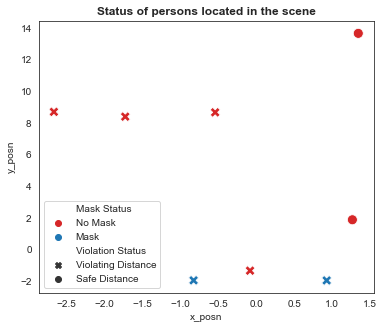

In [125]:
# plot heatmap of risk based on weights formed above
fig, ax = plt.subplots(1, 1, figsize=(6,5))

# plot top-down view locations of all persons in the scene
sns.scatterplot(data=frame_df, x='x_posn', y='y_posn', ax=ax,
                hue='Mask Status', style='Violation Status', s=100, 
                palette=MASK_COLOR_MAP, legend='full',
                markers=DIST_STYLE_MAP)
plt.title("Status of persons located in the scene", weight="bold")
plt.legend(loc="best")
plt.show()

Lets simulate some weights, by making those people without masks a risk, whilst those with are safe. We can then plot a density heatmap showing the locations of all those without a mask:

In [126]:
# determine weights using sum of wearing mask and whether they're violating distance
weights = 1 - frame_df['mask_preds'].values
weights = weights + (1 - frame_df['respect_social_distancing'])

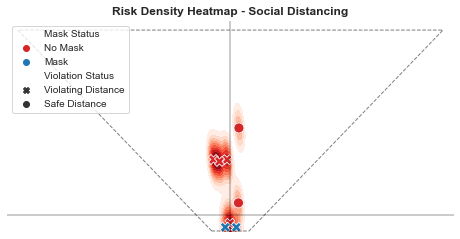

In [127]:
# plot heatmap of risk based on weights formed above
fig, ax = plt.subplots(1, 1, figsize=(8,7))

# get observed area and limits of our scene top-down plot
limits = np.array([[-img_dims[0]/2, -img_dims[1]/2], 
                   [-img_dims[0]/2, img_dims[1]/2], 
                   [img_dims[0]/2, img_dims[1]/2], 
                   [img_dims[0]/2, -img_dims[1]/2], 
                   [-img_dims[0]/2, -img_dims[1]/2]])

# get x and y limits for scene
limits_y = (frame_params[0] * limits[:, 1] / 
                (frame_params[2]*np.sin(frame_params[1])**2 - 
                 limits[:, 1]*np.cos(frame_params[1])*np.sin(frame_params[1])))
limits_x = limits_y * limits[:, 0] * np.sin(frame_params[1]) / limits[:, 1]
ax.plot(limits_x, limits_y, '--k', linewidth = 1, alpha = 0.5)            
    
# get axis and limits
m_x, M_x = np.min(limits_x)*1.05, np.max(limits_x)*1.05
m_y, M_y = np.min(limits_y)*1.05, np.max(limits_y)*1.05

ax.plot([0, 0], [m_y, M_y], '-k', linewidth = 2, alpha = 0.2)
ax.plot([m_x, M_x], [0, 0], '-k', linewidth = 2, alpha = 0.2)

# plot density heatmap on our axis
sns.kdeplot(x=frame_posns[:, 0], y=frame_posns[:, 1], shade=True, ax=ax,
            bw_adjust=0.5, cmap="Reds", weights=weights, alpha=0.95)

# plot top-down view locations of all persons in the scene
sns.scatterplot(data=frame_df, x='x_posn', y='y_posn', ax=ax,
                hue='Mask Status', style='Violation Status', s=100,
                palette=MASK_COLOR_MAP, legend='full',
                markers=DIST_STYLE_MAP)

# set appropriate axis limits
ax.set_xlim(m_x, M_x)
ax.set_ylim(m_y, M_y)
ax.set_aspect('equal')

plt.title("Risk Density Heatmap - Social Distancing", weight="bold")
plt.legend(loc="upper left")
plt.axis("off")
plt.show()

As shown, the heatmap shows areas where people aren't wearing masks and are in close-proximity as more dangerous, whilst those areas where people are social distancing with masks are much lower risk.

Lets make this into a function for more convenient plotting of density heatmaps:

In [128]:
def plot_density_heatmap(person_df, sample_weights, 
                         hgraphy_params, image_dims, 
                         figsize=(7,6), 
                         title="Risk Density Heatmap"):
    """ Helper function for plotting density heatmap of scene on top-down
        view obtained from homography techniques.
    
    Args:
        person_df (pd.DataFrame) : Person results for chosen frame.
        sample_weights (np.ndarray): risk-based weights for each sample.
        hgraphy_params (np.ndarray) : Array of three elements, containing
            frame homography H, theta & f, precisely as so: [H, theta, f].
        image_dims (np.array) : Array containing x and y dims of scene image.
        figsize (tuple): tuple of desired figure size to plot
    """
    # get x and y co-ords of persons for kde plot
    frame_posns = np.stack(person_df['position'].apply(np.array).values, 
                           axis=0)
    
    # break person positions into two seperate columns
    person_df['x_posn'] = person_df['position'].apply(lambda x : x[0])
    person_df['y_posn'] = person_df['position'].apply(lambda x : x[1])

    # set more readable output prediction labels for our risk-features
    person_df['Mask Status'] = person_df['mask_preds'].replace(MASK_PREDS_IDS)
    respect_col = 'respect_social_distancing'
    person_df['Violation Status'] = person_df[respect_col].replace(SOCIAL_DIST_IDS)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # get observed area and limits of our scene top-down plot
    limits = np.array([[-image_dims[0]/2, -image_dims[1]/2], 
                       [-image_dims[0]/2, image_dims[1]/2], 
                       [image_dims[0]/2, image_dims[1]/2], 
                       [image_dims[0]/2, -image_dims[1]/2], 
                       [-image_dims[0]/2, -image_dims[1]/2]])
    
    # get x and y limits for scene
    limits_y = (hgraphy_params[0] * limits[:, 1] / 
                (hgraphy_params[2]*np.sin(hgraphy_params[1])**2 - 
                 limits[:, 1]*np.cos(hgraphy_params[1])*np.sin(hgraphy_params[1])))
    
    limits_x = limits_y * limits[:, 0] * np.sin(hgraphy_params[1]) / limits[:, 1]
    ax.plot(limits_x, limits_y, '--k', linewidth = 1, alpha = 0.5)            
    
    # get axis and limits
    m_x, M_x = np.min(limits_x)*1.05, np.max(limits_x)*1.05
    m_y, M_y = np.min(limits_y)*1.05, np.max(limits_y)*1.05

    ax.plot([0, 0], [m_y, M_y], '-k', linewidth = 2, alpha = 0.2)
    ax.plot([m_x, M_x], [0, 0], '-k', linewidth = 2, alpha = 0.2)

    # plot density heatmap on our axis
    sns.kdeplot(x=frame_posns[:, 0], y=frame_posns[:, 1], 
                shade=True, ax=ax, bw_adjust=0.5, cmap="Reds", 
                weights=sample_weights, alpha=0.95)

    # plot top-down view locations of all persons in the scene
    sns.scatterplot(data=person_df, x='x_posn', y='y_posn', ax=ax,
                    hue='Mask Status', style='Violation Status', s=100,
                    palette=MASK_COLOR_MAP, legend='full',
                    markers=DIST_STYLE_MAP)

    # set appropriate axis limits
    ax.set_xlim(m_x, M_x)
    ax.set_ylim(m_y, M_y)
    ax.set_aspect('equal')

    plt.title(title, weight="bold")
    plt.legend(loc="upper left")
    plt.axis("off")
    plt.show()
    
def get_frame_data(person_df, frame_df, frame_id):
    """ Helper function for obtaining data required for plotting density
        heat map plots for each scene (see plot_density_heatmap()) 
    
    Args:
        person_df (pd.DataFrame) : Person results for chosen frame.
        frame_df (np.ndarray): Higher-level frame results for each frame.
        frame_id (str) : id of frame to plot density heatmap for.
    
    Returns:
        (frame_person_df, frame_params, img_dims) : tuple including
                Person results, homography params, and img dimensions 
                for the chosen frame given by 'frame_id' argument.
    """
    # select frame from results above for plotting
    frame_mask = person_df['image_id'] == frame_id
    frame_person_df = person_df.loc[frame_mask].copy()

    # get homography params for the chosen frame
    frame_params = frame_df.loc[frame_df['image_id'] == frame_id, 
                    ['frame_H', 'frame_theta', 'frame_f']].values[0]

    # get frame image dimensions for plotting purposes
    img_dims = frame_df.loc[frame_df['image_id'] == frame_id, 
                            ['frame_dim_x', 'frame_dim_y']].values[0]
    
    return frame_person_df, frame_params, img_dims

In [144]:
# reset plotting settings (if not already done)
%matplotlib inline
sns.set_style('white')

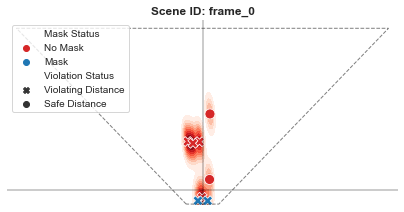

In [145]:
chosen_id = 'frame_0'

# get appropriate results for chosen frame to plot our density heatmap
frame_person_results, frame_params, img_dims = get_frame_data(person_results, 
                                                              frame_results, 
                                                              chosen_id)

# determine weights using sum of wearing mask and whether they're violating distance
weights = 1 - frame_person_results['mask_preds'].values
weights = weights + (1 - frame_person_results['respect_social_distancing'])

plot_density_heatmap(frame_person_results, weights, frame_params, 
                     img_dims, figsize=(7,6), title=f"Scene ID: {chosen_id}")

Lets iterate through all of our frames for the video above and plot the heatmap:

In [146]:
# reset plotting settings (if not already done)
%matplotlib inline
sns.set_style('white')

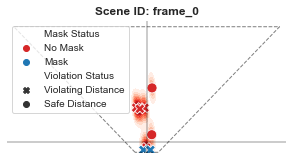

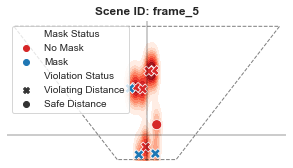

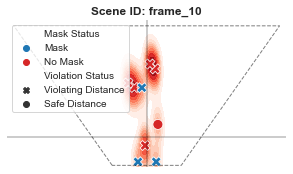

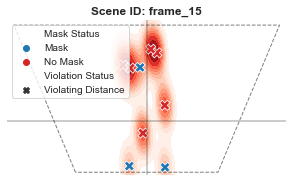

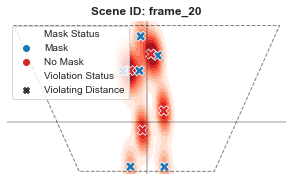

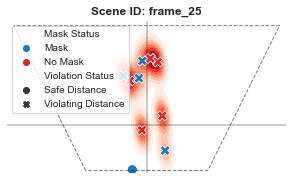

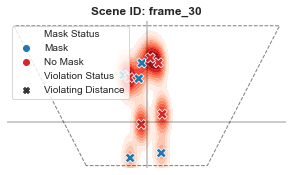

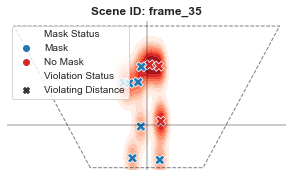

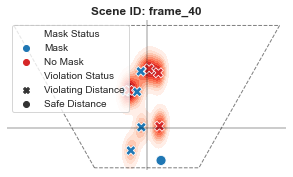

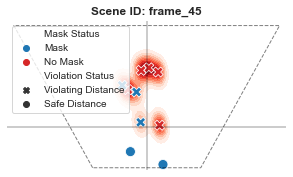

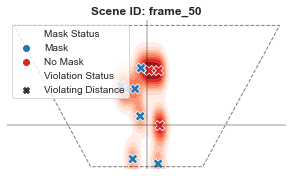

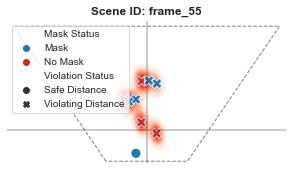

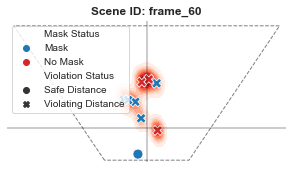

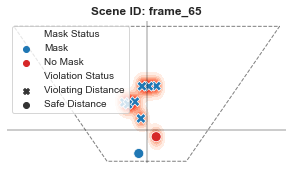

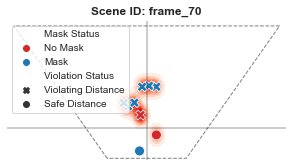

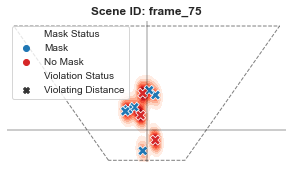

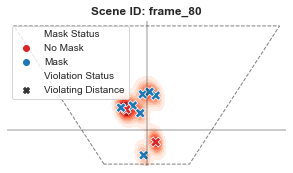

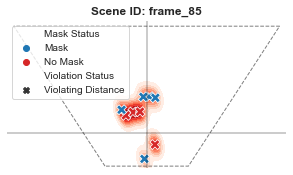

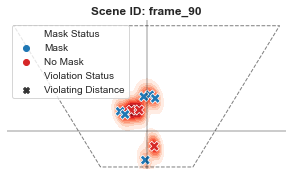

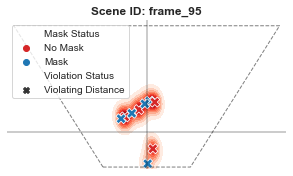

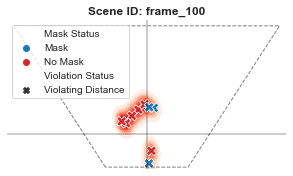

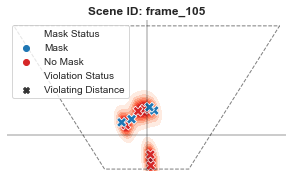

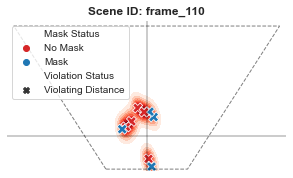

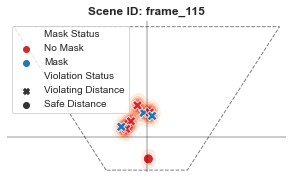

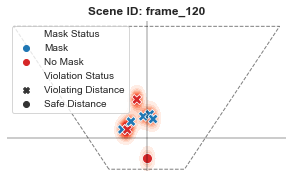

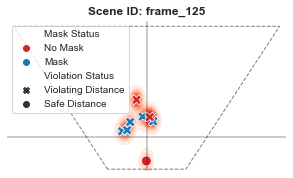

In [147]:
for chosen_id in list(frame_results['image_id'].unique()):
    # get appropriate results for chosen frame to plot our density heatmap
    frame_person_results, frame_params, img_dims = get_frame_data(person_results, 
                                                                  frame_results, 
                                                                  chosen_id)

    # determine weights using sum of wearing mask and whether they're violating distance
    weights = 1 - frame_person_results['mask_preds'].values
    weights = weights + (1 - frame_person_results['respect_social_distancing'])

    plot_density_heatmap(frame_person_results, weights, frame_params, 
                         img_dims, figsize=(5,4), title=f"Scene ID: {chosen_id}")

Lets improve on this by returning the plotted heatmap as an image array, rather than plotting it in matplotlib:

In [148]:
def get_density_heatmap(person_df, sample_weights, 
                        hgraphy_params, image_dims, 
                        figsize=(7,6), 
                        title="Risk Density Heatmap"):
    """ Helper function for plotting density heatmap of scene on top-down
        view obtained from homography techniques.
    
    Args:
        person_df (pd.DataFrame) : Person results for chosen frame.
        sample_weights (np.ndarray): risk-based weights for each sample.
        hgraphy_params (np.ndarray) : Array of three elements, containing
            frame homography H, theta & f, precisely as so: [H, theta, f].
        image_dims (np.array) : Array containing x and y dims of scene image.
        figsize (tuple): tuple of desired figure size to plot
    """
    # get x and y co-ords of persons for kde plot
    frame_posns = np.stack(person_df['position'].apply(np.array).values, 
                           axis=0)
    
    # break person positions into two seperate columns
    person_df['x_posn'] = person_df['position'].apply(lambda x : x[0])
    person_df['y_posn'] = person_df['position'].apply(lambda x : x[1])

    # set more readable output prediction labels for our risk-features
    person_df['Mask Status'] = person_df['mask_preds'].replace(MASK_PREDS_IDS)
    respect_col = 'respect_social_distancing'
    person_df['Violation Status'] = person_df[respect_col].replace(SOCIAL_DIST_IDS)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # get observed area and limits of our scene top-down plot
    limits = np.array([[-image_dims[0]/2, -image_dims[1]/2], 
                       [-image_dims[0]/2, image_dims[1]/2], 
                       [image_dims[0]/2, image_dims[1]/2], 
                       [image_dims[0]/2, -image_dims[1]/2], 
                       [-image_dims[0]/2, -image_dims[1]/2]])
    
    # get x and y limits for scene
    limits_y = (hgraphy_params[0] * limits[:, 1] / 
                (hgraphy_params[2]*np.sin(hgraphy_params[1])**2 - 
                 limits[:, 1]*np.cos(hgraphy_params[1])*np.sin(hgraphy_params[1])))
    
    limits_x = limits_y * limits[:, 0] * np.sin(hgraphy_params[1]) / limits[:, 1]
    ax.plot(limits_x, limits_y, '--k', linewidth = 1, alpha = 0.5)            
    
    # get axis and limits
    m_x, M_x = np.min(limits_x)*1.05, np.max(limits_x)*1.05
    m_y, M_y = np.min(limits_y)*1.05, np.max(limits_y)*1.05

    ax.plot([0, 0], [m_y, M_y], '-k', linewidth = 2, alpha = 0.2)
    ax.plot([m_x, M_x], [0, 0], '-k', linewidth = 2, alpha = 0.2)

    # plot density heatmap on our axis
    sns.kdeplot(x=frame_posns[:, 0], y=frame_posns[:, 1], 
                shade=True, ax=ax, bw_adjust=0.8, cmap="Reds", 
                weights=sample_weights, alpha=0.95)

    # plot top-down view locations of all persons in the scene
    sns.scatterplot(data=person_df, x='x_posn', y='y_posn', ax=ax,
                    hue='Mask Status', style='Violation Status', s=100, 
                    palette=MASK_COLOR_MAP, legend='full',
                    markers=DIST_STYLE_MAP)

    # set appropriate axis limits
    ax.set_xlim(m_x, M_x)
    ax.set_ylim(m_y, M_y)
    ax.set_aspect('equal')

    plt.title(title, weight="bold")
    plt.legend(loc="upper left")
    plt.axis("off")
    plt.tight_layout()
    
    # save plot as BytesIO object
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    plt.close()
    
    return np.array(img)

We can now more conveniently collect our heatmap plots as arrays, rather than matplotlib plots, like so:

In [149]:
# reset plotting settings (if not already done)
%matplotlib inline
sns.set_style('white')

In [150]:
chosen_id = 'frame_0'

# get appropriate results for chosen frame to plot our density heatmap
frame_person_results, frame_params, img_dims = get_frame_data(person_results, 
                                                              frame_results, 
                                                              chosen_id)

# determine weights using sum of wearing mask and whether they're violating distance
weights = 1 - frame_person_results['mask_preds'].values
weights = weights + (1 - frame_person_results['respect_social_distancing'])

result_img = get_density_heatmap(frame_person_results, weights, frame_params, 
                                 img_dims, figsize=(7,6), title=f"Scene ID: {chosen_id}")

This is more convenient, since we can store the array for later, and even stack all of the heatmap visualisations for a scene over a desired number of timesteps. In addition, we could also save many visualisations as a video, for display on the dashboard.

We can also plot it easily too, if required, like so:

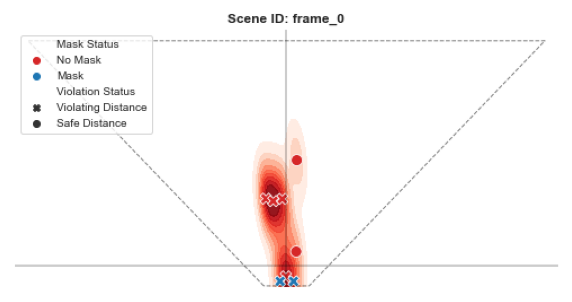

In [151]:
plt.figure(figsize=(10,7))
plt.imshow(result_img)
plt.axis('off')
plt.show()

Lets gather all of the heatmap visualisations as one large array, of the following shape: (n_frames, height, width, channels):

In [152]:
# reset plotting settings (if not already done)
%matplotlib inline
sns.set_style('white')

In [153]:
# if true, use only final set of homography params for scene
# helps keep things smoother / more consistent throughout
USE_FINAL_HOMOGRAPHY = True

frame_heatmaps = []

# if chosen use only final set of homography params for video of scene
if USE_FINAL_HOMOGRAPHY:
    _, final_frame_params, _ = get_frame_data(person_results, frame_results, 
                                list(frame_results['image_id'].unique())[-1])

for chosen_id in list(frame_results['image_id'].unique()):
    
    
    # get appropriate results for chosen frame to plot our density heatmap
    frame_person_results, frame_params, img_dims = get_frame_data(person_results, 
                                                                  frame_results, 
                                                                  chosen_id)
    
    # modify params to final params if selected
    if USE_FINAL_HOMOGRAPHY:
        frame_params = final_frame_params.copy()
        
    # determine weights using sum of wearing mask and whether they're violating distance
    weights = 1 - frame_person_results['mask_preds'].values
    weights = weights + (1 - frame_person_results['respect_social_distancing'])

    frame_heatmap = get_density_heatmap(frame_person_results, weights, frame_params, 
                                        img_dims, figsize=(7,6), 
                                        title=f"Scene ID: {chosen_id}")
    
    frame_heatmaps.append(frame_heatmap)

**Animation of all heatmaps for current scene:**

Lets show this as a sequence of heatmaps for the original video.

**Note** - you need to ensure you run matplotlib in notebook mode (or open the plot in a pop-out window) in order to visualise the animation sequence below.

In [1]:
from matplotlib import animation

# need to enable matplotlib notebook to show animations
%matplotlib notebook

In [2]:
fig, ax = plt.subplots(figsize=(7,6))

ims = []
for i in range(len(frame_heatmaps)):
    im = ax.imshow(frame_heatmaps[i], animated=True)
    ims.append([im])

# animate our heatmap based on modelling fps chosen earlier
# make this slower (by 50%) to improve readability in this example
ani = animation.ArtistAnimation(fig, ims, interval=2000/MODELLING_FPS, 
                                blit=True, repeat=False)
plt.show()

NameError: name 'plt' is not defined

Lets save this animation as a .gif for convenience of demonstrating various results:

In [159]:
f = f"{TEST_VIDEO_DIR}/{TEST_VIDEO_FILE[:-4]}_heatmap_animation.gif" 
writergif = animation.PillowWriter(fps=MODELLING_FPS) 
ani.save(f, writer=writergif)

TO-DO:
- Improve on this to give much cleaner results above, using a constant set of homography parameters for the entire scene (this will prevent the plot bouncing around).
- Work out a means of getting a suitable underlay of the top-down area for the scene, which will help represent the risky locations throughout that scene more effectively.
- Extend the work with heatmaps to produce a heatmap averaged over n timeframes, which will give an overall risk rating heatmap for that area over a designated time-period.